In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve
import matplotlib.pyplot as plt
pd.set_option('display.max_columns',None)

In [2]:
df = pd.read_csv(r'C:\Users\marek\OneDrive\Pulpit\Inzynierka\bank-additional-full.csv', sep=';')
columns_to_drop = ['duration','euribor3m','emp.var.rate','cons.price.idx','cons.conf.idx','nr.employed']
for column in columns_to_drop:
    df.drop(column, axis=1, inplace=True)
columns_to_replace_unknown = df.columns.difference(['default','housing','loan'])
df[columns_to_replace_unknown] = df[columns_to_replace_unknown].copy().replace('unknown', np.nan)

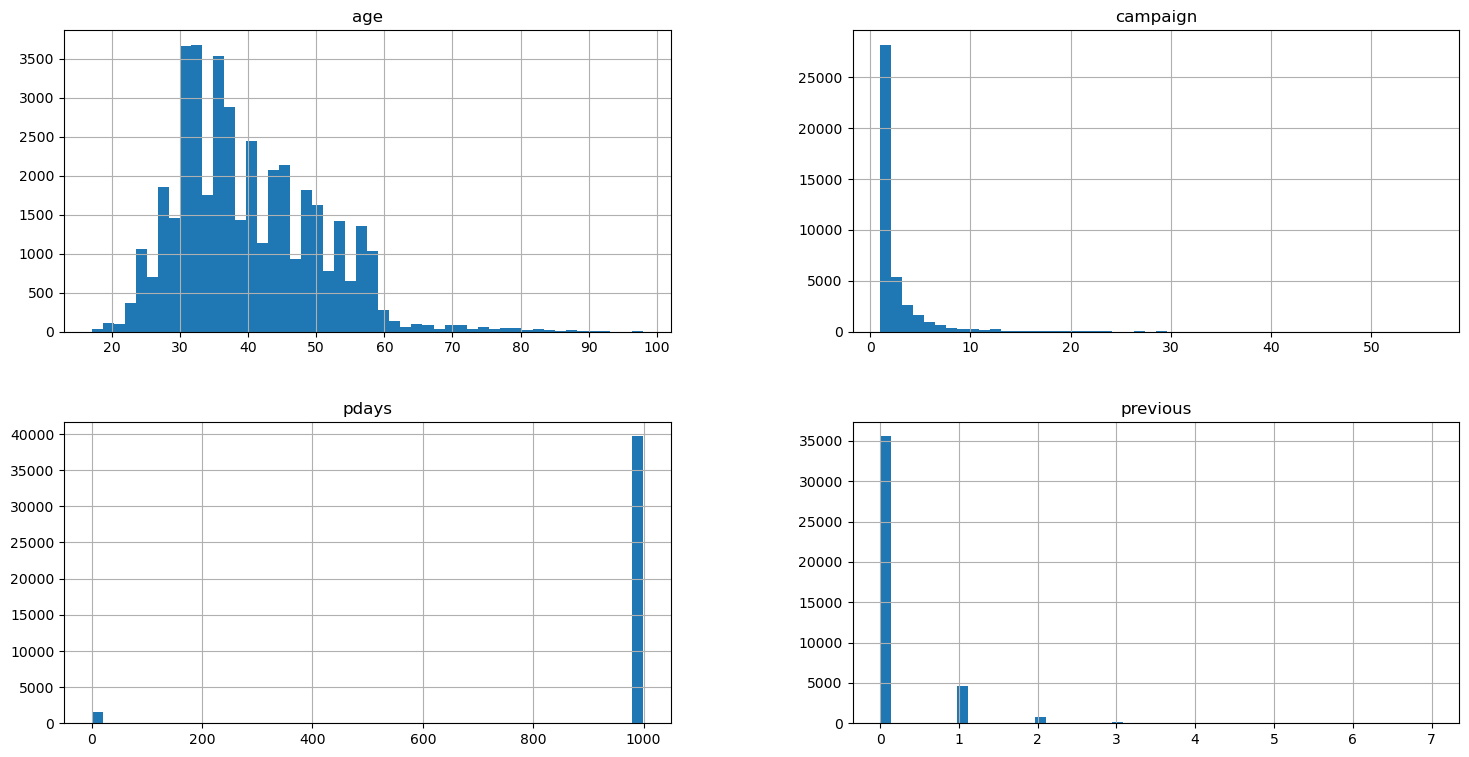

In [3]:
df.hist(bins=50, figsize=(18,9))
plt.show()

In [4]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,no


In [5]:
def scaleMinMax(dataFrame, columnName):
    scaler = MinMaxScaler()
    series = dataFrame[columnName]
    scaled_data = scaler.fit_transform(series.values.reshape(-1,1))
    scaled_series = pd.Series(scaled_data.flatten(), index=series.index)
    dataFrame[columnName] = scaled_series


def createMetrics(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred,  labels=[1,0])

    plt.figure(figsize=(6, 4))
    plt.imshow(np.log1p(cm), interpolation='nearest', cmap='Greens')
    plt.title('Macierz pomyłek (log)')
    plt.colorbar()
    
    plt.xticks([])
    plt.yticks([])
    
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if i == 0 and j == 0:
                plt.text(j, i, f'TP={cm[i, j]}', horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2 else "black")
            elif i == 0 and j == 1:
                plt.text(j, i, f'FN={cm[i, j]}', horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2 else "black")
            elif i == 1 and j == 0:
                plt.text(j, i, f'FP={cm[i, j]}', horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2 else "black")
            elif i == 1 and j == 1:
                plt.text(j, i, f'TN={cm[i, j]}', horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2 else "black")
    
    plt.tight_layout()
    plt.show()

    print(classification_report(y_test, y_pred))

In [6]:
#najpierw skalujemy kolumnę wiek w wartości od 0 do 1, kolumna age nie posiada danych brakujących
scaleMinMax(df, 'age')

In [7]:
#teraz zajmiemy się kolumnami Job i Marital, dla obu zastosujemy dummmy typing, usuwając najpierw rekordy z NaN (wcześniej unknown)
categorical_for_dummies = ['job', 'marital']
[df.dropna(subset=x, inplace=True) for x in categorical_for_dummies]
#kolumny default, housing, loan i contact w wyniku dalszej analizy poddajemy również takiemu typowaniu
categorical_for_dummies.extend(['default', 'housing','loan','contact','poutcome'])
df = pd.get_dummies(df, columns=categorical_for_dummies)

In [8]:
#teraz zajmiemy się edukacją zamieniłem poziom nauki na wartośći 0-6 obrazujące ile ktoś się uczył (jaki uzyskał tytuł)
#dodatkowo wartości brakujące uzupełniłem średnią, na koniec zastosowałem skaler
df['education'].replace(['illiterate','basic.4y','basic.6y','basic.9y','high.school','professional.course',
                         'university.degree'], [0,1,2,3,4,5,6], inplace=True)
df['education'].fillna(df['education'].mean() ,inplace=True)

scaleMinMax(df, 'education')

In [9]:
#teraz zamienimy miesiące i dni tygodnia na wartośći 1-12 oraz 1-5, następnie poddamy je skalowaniu
df['month'].replace(['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'],
                     [1,2,3,4,5,6,7,8,9,10,11,12], inplace=True) 
df['day_of_week'].replace(['mon','tue','wed','thu','fri'], [1,2,3,4,5], inplace=True)

scaleMinMax(df, 'month')
scaleMinMax(df, 'day_of_week')

In [10]:
#Teraz zajmiemy się kolumną campaign, odrzucimy 0.5% największych ilości kontaktów. Powyżej 19 kontaktów liczba procent współczynnik sukcesu
#wyniosl w naszym zbiorze 1/186, w aplikacji jeśli ilość kontaktów byłaby większa, ustawimy ją na 19
quantile_995 = df['campaign'].quantile(0.995)
df = df[df['campaign'] <= quantile_995]
scaleMinMax(df, 'campaign')

In [11]:
#dostawiłem dodatkową kolumnę z brakiem kontaktu wcześniejszego oraz wykonałem log10, by ułatwił uczeniu maszynowemu predykcję
df['not_contacted_before'] = df['pdays'] == 999
df['pdays'] = df['pdays'].apply(lambda x: np.log10(x) if x > 0 else 0)

In [12]:
#dla previous wykonałem tylko standardowy scaling MinMax
scaleMinMax(df, 'previous')

In [13]:
#df.where((df['pdays'] == 999) & (df['y'] == 1)).dropna()
#df.where((df['campaign'] > 19) & (df['y'] == 1)).dropna()

In [14]:
df['y'].replace(['no', 'yes'], [0, 1], inplace=True)
X = df.drop('y', axis=1)
Y = df['y']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.15, random_state=42)

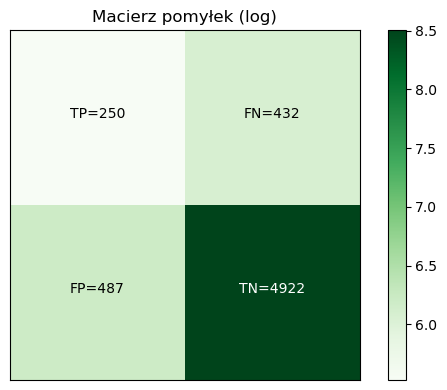

              precision    recall  f1-score   support

           0       0.92      0.91      0.91      5409
           1       0.34      0.37      0.35       682

    accuracy                           0.85      6091
   macro avg       0.63      0.64      0.63      6091
weighted avg       0.85      0.85      0.85      6091



In [16]:
from sklearn.tree import DecisionTreeClassifier
#Drzewa decyzyjne
model = DecisionTreeClassifier(max_depth = 3,class_weight='balanced', random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

createMetrics(y_test, y_pred)

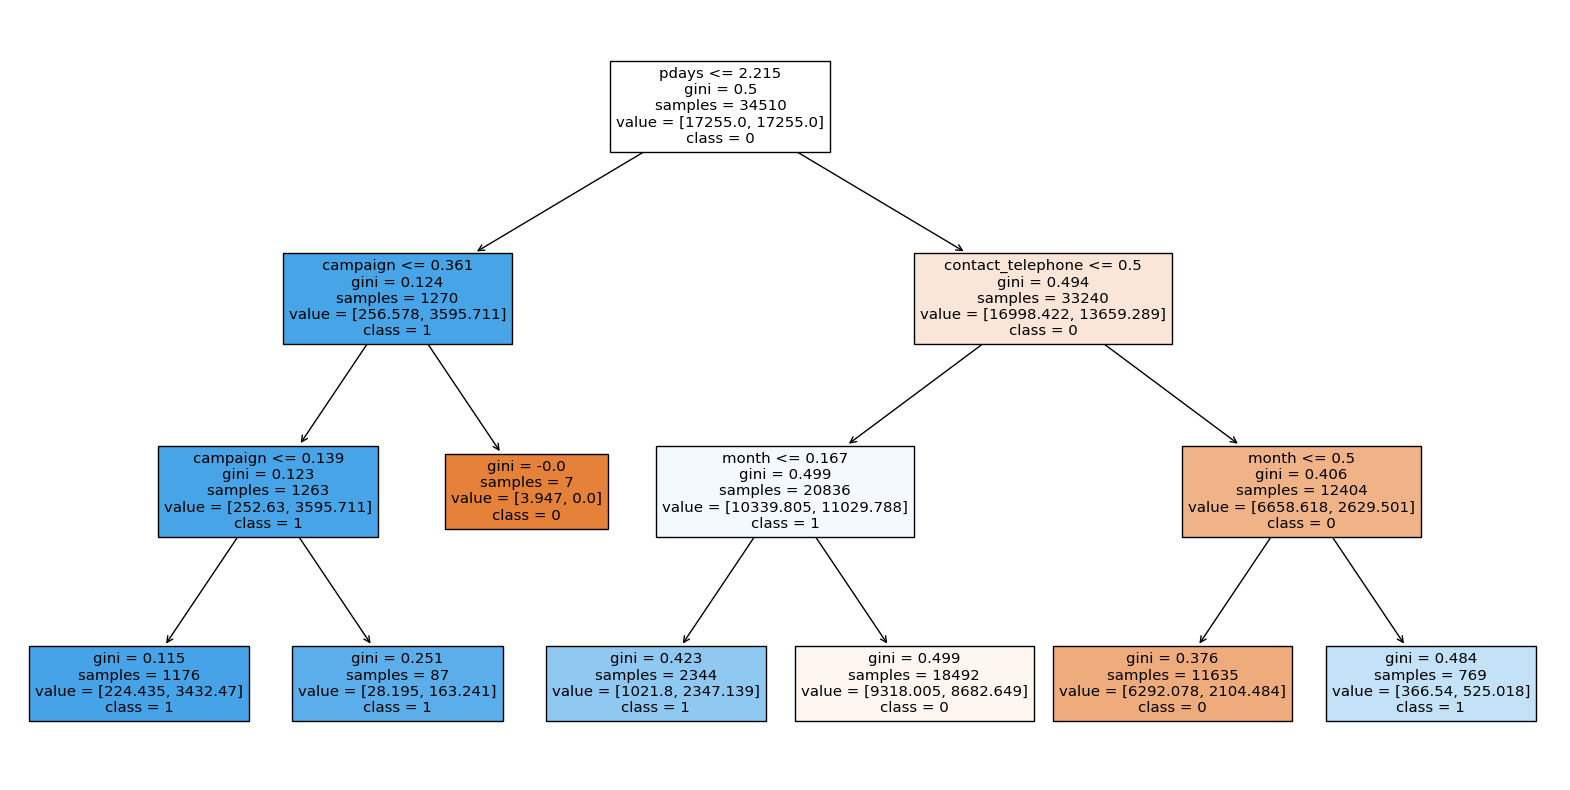

In [17]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20,10)) 

feature_names = X_train.columns 
class_names = model.classes_

feature_names = list(map(str, feature_names))
class_names = list(map(str, class_names))

plot_tree(model, feature_names=feature_names, class_names=class_names, filled=True)
plt.show()

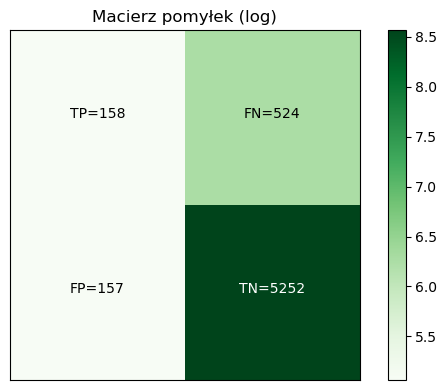

              precision    recall  f1-score   support

           0       0.91      0.97      0.94      5409
           1       0.50      0.23      0.32       682

    accuracy                           0.89      6091
   macro avg       0.71      0.60      0.63      6091
weighted avg       0.86      0.89      0.87      6091



In [18]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

createMetrics(y_test, y_pred)

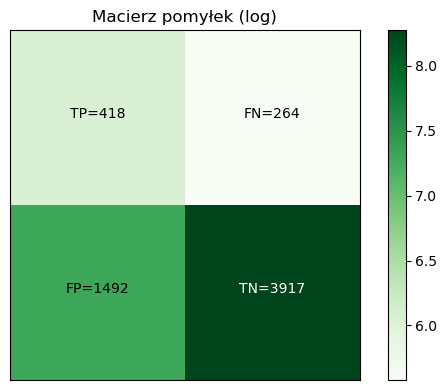

              precision    recall  f1-score   support

           0       0.94      0.72      0.82      5409
           1       0.22      0.61      0.32       682

    accuracy                           0.71      6091
   macro avg       0.58      0.67      0.57      6091
weighted avg       0.86      0.71      0.76      6091



In [19]:
from sklearn.svm import SVC

model = SVC(class_weight='balanced', random_state=42, probability=True)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

createMetrics(y_test, y_pred)

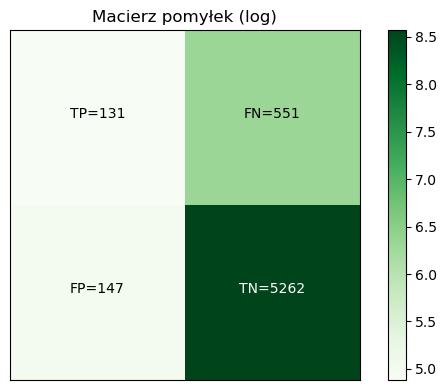

              precision    recall  f1-score   support

           0       0.91      0.97      0.94      5409
           1       0.47      0.19      0.27       682

    accuracy                           0.89      6091
   macro avg       0.69      0.58      0.61      6091
weighted avg       0.86      0.89      0.86      6091



In [20]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

createMetrics(y_test, y_pred)

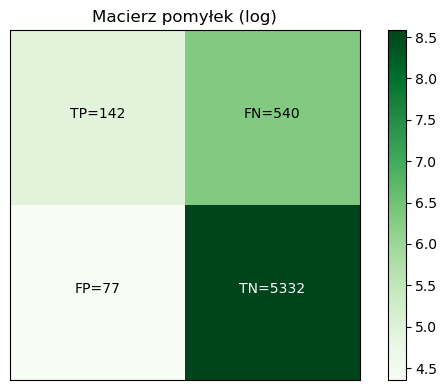

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      5409
           1       0.65      0.21      0.32       682

    accuracy                           0.90      6091
   macro avg       0.78      0.60      0.63      6091
weighted avg       0.88      0.90      0.87      6091



In [21]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

createMetrics(y_test, y_pred)

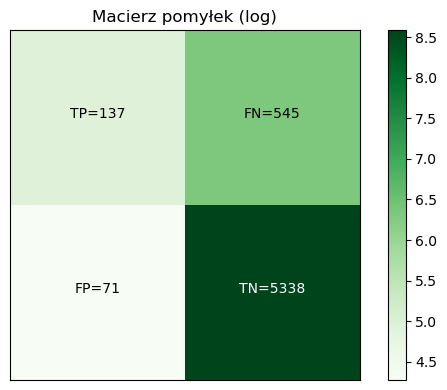

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      5409
           1       0.66      0.20      0.31       682

    accuracy                           0.90      6091
   macro avg       0.78      0.59      0.63      6091
weighted avg       0.88      0.90      0.87      6091



In [22]:
from sklearn.ensemble import AdaBoostClassifier

model = AdaBoostClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

createMetrics(y_test, y_pred)

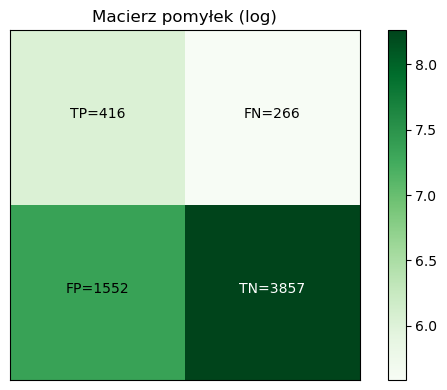

              precision    recall  f1-score   support

           0       0.94      0.71      0.81      5409
           1       0.21      0.61      0.31       682

    accuracy                           0.70      6091
   macro avg       0.57      0.66      0.56      6091
weighted avg       0.85      0.70      0.75      6091



In [23]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

createMetrics(y_test, y_pred)

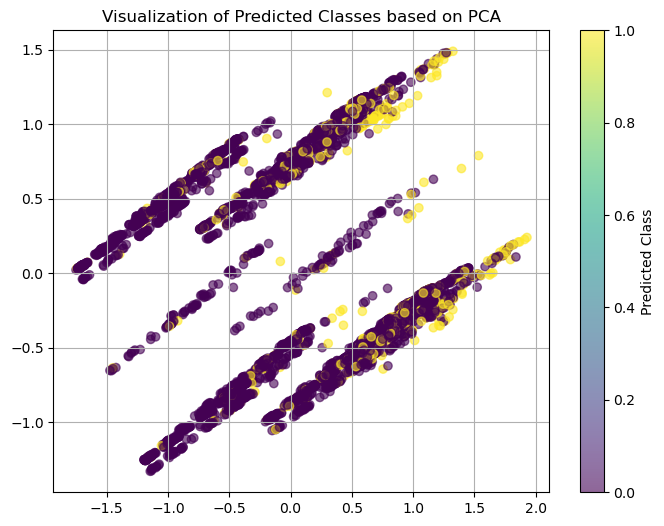

In [28]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test)

# Wykres punktowy
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_test, cmap='viridis', alpha=0.6)
plt.colorbar(label='Predicted Class')
plt.title('Visualization of Predicted Classes based on PCA')
plt.grid(True)
plt.show()

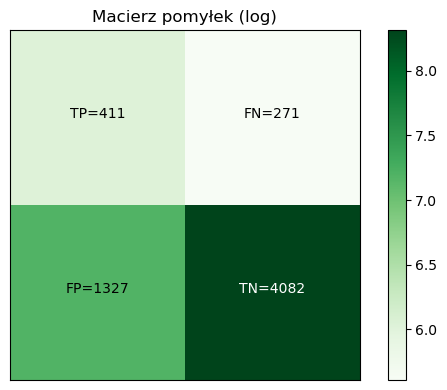

              precision    recall  f1-score   support

           0       0.94      0.75      0.84      5409
           1       0.24      0.60      0.34       682

    accuracy                           0.74      6091
   macro avg       0.59      0.68      0.59      6091
weighted avg       0.86      0.74      0.78      6091



In [25]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(
    estimators=[
        ('svc', SVC(class_weight='balanced', random_state=42, probability=True)),
        ('dtc',DecisionTreeClassifier(max_depth = 10,class_weight='balanced', random_state=42)),
        ('gnb',GaussianNB())
    ]
)
voting_clf.fit(X_train, y_train)
y_pred = voting_clf.predict(X_test)

createMetrics(y_test, y_pred)

In [26]:
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    'svc__C': [0.1, 1, 10, 100],
    'svc__kernel': ['linear', 'rbf', 'poly'],
    'dtc__max_depth': [None, 10, 20, 30, 40],
    'dtc__min_samples_split': [2, 5, 10, 15],
    'gnb__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]
}

# Przeszukiwanie hiperparametrów
random_search = RandomizedSearchCV(voting_clf, param_distributions, n_iter=50, cv=5, scoring='recall', verbose=1, random_state=42)
random_search.fit(X_train, y_train)

# Wyniki
print("Najlepsze parametry:")
print(random_search.best_params_)
y_pred = random_search.predict(X_test)

createMetrics(y_test, y_pred)